In [16]:
import arviz as az
import numpy as np
from scipy.stats import binom, mode, expon, halfnorm, norm
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm

import warnings
# To remove irritating deprecation warning for Arviz
warnings.filterwarnings('ignore')

%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [78]:
n = 15
w = 8

p_grid = np.linspace(start=0, stop=1, num=1000)
prior = norm.pdf(loc=.1, scale=.05, x=p_grid)
likelihood = binom.pmf(w, n, p_grid)
posterior = likelihood*prior
posterior = posterior/np.sum(posterior)

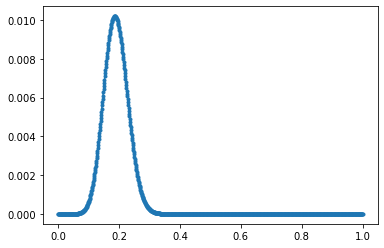

In [79]:
plt.plot(p_grid, posterior, linestyle='--', marker='.')
plt.show()

In [4]:
# Chapter 5 scratch
path = '/home/jonathan/Projects/LearningReferences/resources/Rethinking_2/Data/WaffleDivorce.csv'
data = pd.read_csv(path, delimiter=';')

In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [42]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"] + bA * data["MedianAgeMarriage_std"]
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()
    m_5_3_ppc = pm.sample_posterior_predictive(m_5_3_trace, var_names=["mu", "divorce_rate_std"], samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [50]:
mu_mean = m_5_3_ppc["mu"].mean(axis=0)
mu_hpd = az.hpd(m_5_3_ppc["mu"], hdi_prob=0.89)

D_sim = m_5_3_ppc["divorce_rate_std"].mean(axis=0)
D_PI = az.hpd(m_5_3_ppc["divorce_rate_std"], hdi_prob=0.89)

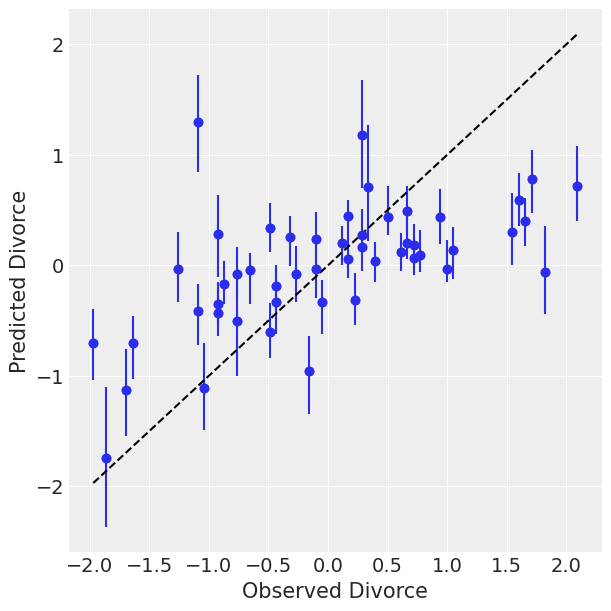

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(D_sim - mu_hpd.T),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");